In [92]:
import wordcloud
import boto3
import re
import pprint
from nltk.tokenize import sent_tokenize
%reload_ext autoreload

In [93]:
import json
import os

config_file_path = os.environ['VIRTUAL_ENV'] + '/config.json'

with open(config_file_path) as f:
    config = json.load(f)
    # authentication 
    AWS_ACCESS_KEY = config['access_key']
    AWS_SECRET_ACCESS_KEY = config['secret_key']
    AWS_REGION = boto3.Session().region_name

    input_file_path = config['input_path']
    output_file_path = config['output_path']

In [94]:
# configuration AWS
client_comprehend = boto3.client(
    'comprehend',
    region_name=AWS_REGION,
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

In [95]:
def getSentiment(text, isCombined):
    ## find topics 
    keys = set()
    avgSentiment = 0.0
    
    response_key_phrases = client_comprehend.detect_key_phrases(
        Text=text,
        LanguageCode='en'
    )
    ## get the key phrases
    key_phrases = list(set([x['Text'] for x in response_key_phrases['KeyPhrases'] if float(x['Score'])*100 > 98.0]))


    response_sentiment = client_comprehend.detect_sentiment(
        Text=text,
        LanguageCode='en'
    )
    
#     sentiment = response_sentiment['Sentiment']
    sentimentScore = response_sentiment['SentimentScore']['Negative']
#         keys = keys.union(set(key_phrases))    
    return key_phrases, sentimentScore

In [96]:
def analyseSentence(text):
    topics = []
    avgSentiment = 0.0
    # split input string with [, .] delimeters
#     splitedSentence = re.split('; |, |\.|\*|\n', text)
    return getSentiment(text, True)

In [97]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
en_stop = stopwords.words('english')

#remove stopwords
def removeStopwords(topicList):
    stopedWords = []
    for topic in topicList:
        wordList = topic.split(' ')
        for word in wordList:
            if not word in en_stop:
                stopedWords.append(word)        
    return stopedWords

[nltk_data] Downloading package stopwords to /home/nawaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
# project data source file
from dataSource import getData
import pandas as pd

comment_list = getData(input_file_path)

topicColumn = []
sentimentColumn = []
topicCollection = []
topicWithPotential = {}

for comment in comment_list['comments']:
#     from topicModeling import getTopics
#     print(getTopics(comment))
    topics, sentiment = analyseSentence(comment)
    topicWithoutStopwords = removeStopwords(topics)
    topicCollection = topicCollection + topicWithoutStopwords
    # maintainPotaintial
    maintainPotaintial(topicWithoutStopwords, sentiment)
    topicsAsSentence = ','.join([each for each in topics])
    topicColumn.append(topicsAsSentence)
    sentimentColumn.append(sentiment)

In [99]:
def maintainPotaintial(tWithoutStopwords, sentiment):
    for topic in tWithoutStopwords:
        sentiment_ = round(sentiment, 4)
        if topic in topicWithPotential:
            v = topicWithPotential[topic] # Array [total -ve, total freq of word]
            v[0] = v[0] + sentiment_
            v[1] = v[1] + 1.0
        else:
            topicWithPotential[topic] = [sentiment_, 1]
            

In [100]:
# get average percentage of sentiment for each unique word in all comments
all = {k: v[0]/v[1] for k, v in topicWithPotential.items()}
from operator import itemgetter
sorted_by_value = sorted(all.items(), key=itemgetter(1),  reverse=True)

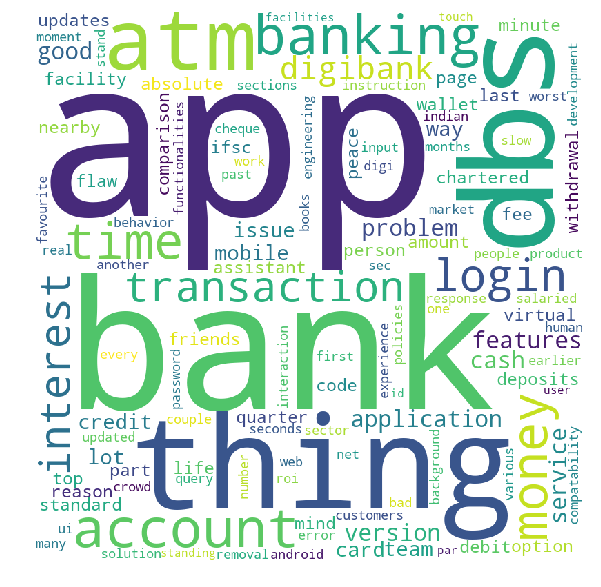

In [101]:
from wordCloud import showWordCloud
showWordCloud(topicCollection)    

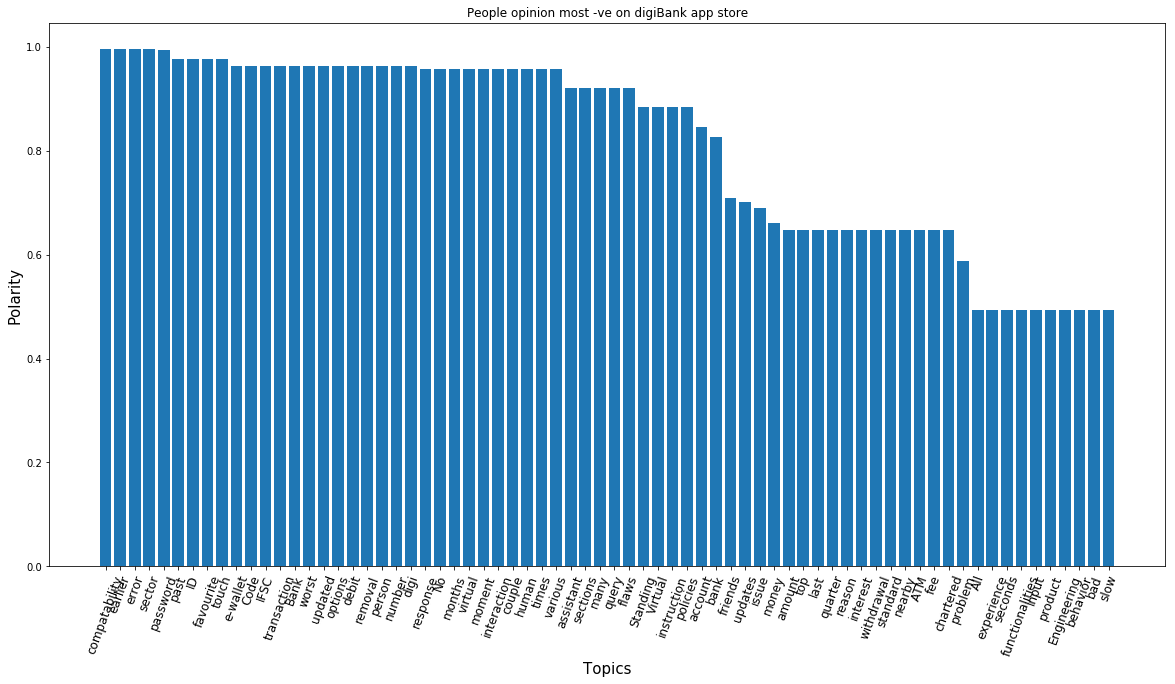

In [103]:
import matplotlib.pyplot as plt
import numpy as np

def showBarCharForSentiment(dataMap):
    # this is for plotting purpose
    labels = []
    polarity = []
  
    for i in dataMap[: 70]:
        labels.append(i[0])
        polarity.append(i[1])

    plt.figure(figsize=(20, 10)) 
    x = np.arange(len(polarity))
    plt.bar(x, polarity)
    plt.xlabel('Topics', fontsize=15)
    plt.ylabel('Polarity', fontsize=15)
    plt.xticks(x, labels, fontsize=12, rotation=70)
    plt.title('People opinion most -ve on digiBank app store')

showBarCharForSentiment(d_sorted_by_value)

In [104]:
import numpy as np

dataToStore = {
    'topic': topicColumn,
    'Negative': sentimentColumn
}
# print(topicCollection)
df = pd.DataFrame(dataToStore)
df.to_csv(output_file_path, sep='\t', encoding='utf-8')